# Transshipment

In [84]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
class Excel:
    def __init__(self, filename):
        self.file = pd.ExcelFile(filename)
    def to_df(self, sheet):
        return pd.read_excel(self.file, sheet_name=sheet, index_col=0)
    def print_sheets(self):
        print(*self.file.sheet_names, sep="\n")

class ModelData:
    """
    Loads and stores data to configure model, and retains important model output data.
    Useful for when a model needs to be re-run many times.
    """
    solver = pe.SolverFactory('glpk')

    def __init__(self, c1, c2, demand, capacity):
        # Model
        self.mod = pe.ConcreteModel()

        # User-provided dataframes
        self.c1, self.c2 = c1, c2
        self.demand = demand
        self.capacity = capacity

        # Starting locations (plants)
        self.DVX = list(self.c1.index)
        # DV Indexes
        self.DV1 = list(self.c1.columns) # Distribution centers
        self.DV2 = list(self.c2.columns) # Warehouses

        # Declare decision variables
        for x in self.DVX:
            setattr(self.mod, x, pe.Var(self.DV1, domain = pe.NonNegativeReals))
        for d in self.DV1:
            setattr(self.mod, d, pe.Var(self.DV2, domain = pe.NonNegativeReals))

        # Store final decision variables
        self.df_dist = pd.DataFrame()
        self.df_plant = pd.DataFrame()
        self.obj_val = None
        self.slack = {} # Dict where each key is constraint name, val is slack
    
    def print_dv_indexes(self):
        for indexes in [md.DV1, md.DV2, md.DVX]:
            print(*indexes, sep=", ")

    def printslack(self):
        has_slack = [c for c in self.slack.keys() if self.slack[c] != 0]
        print(f"The following {len(has_slack)} constraints have slack:")
        print(*[f"Constr {c}: {md.slack[c]}" for c in has_slack], sep="\n")

    def printresult(self):
        print(f"PLANT TO DISTRIBUTOR:\n{self.df_plant}")
        print(f"\nDISTRIBUTOR TO WAREHOUSE:\n{self.df_dist}")
        print(f"\nOBJECTIVE VALUE: ${self.obj_val}")
    
    def clear_components(self):
        # TO SUPPRESS WARNING: Each time function is called, delete component objects
        for attr in list(self.mod.component_objects(pe.Constraint)) + list(self.mod.component_objects(pe.Objective)):
            self.mod.del_component(getattr(self.mod, str(attr)))
    
    def solve(self):
        ModelData.solver.solve(self.mod)
    
    def run(self):
        self.clear_components()

        # ===== OBJECTIVE FUNCTION =====
        products = []
        for x in self.DVX: # Stage 1
            products += [self.c1.loc[x, i] * getattr(self.mod, x)[i] for i in self.DV1]
        for d in self.DV1: # Stage 2
            products += [self.c2.loc[d, i] * getattr(self.mod, d)[i] for i in self.DV2]
        self.mod.obj = pe.Objective(expr = sum(products), sense = pe.minimize)

        # ===== CONSTRAINTS =====
        for x in self.DVX: # Plant -> Dist
            setattr(self.mod, f"con_{x}", pe.Constraint(
                expr = sum(getattr(self.mod, x)[idx] for idx in self.DV1) <= self.capacity.loc[x, "Capacity"]
            ))
        for w in self.DV2: # Dist -> Warehouse
            setattr(self.mod, f"con_{w}", pe.Constraint(
                expr = self.mod.D1[w] + self.mod.D2[w] >= self.demand.loc[w, "Requirement"]
            ))
        for d in self.DV1: # Equal flow for both stages
            setattr(self.mod, f"con_{d}", pe.Constraint(
                expr = sum([getattr(self.mod, d)[w] for w in self.DV2]) == sum([getattr(self.mod, x)[d] for x in self.DVX])
            ))

        self.solve()

        # Save dependent variable outputs to dataframes
        self.df_plant = pd.DataFrame( # Save DVs: plant -> dist
            [[getattr(self.mod, x)[d].value for d in self.DV1] for x in self.DVX], columns=self.DV1, index=self.DVX
        )
        self.df_dist = pd.DataFrame( # Save DVs: dist -> warehouse
            [[getattr(self.mod, d)[w].value for w in self.DV2] for d in self.DV1], columns=self.DV2, index=self.DV1
        )

        # Save objective value
        self.obj_val = round(self.mod.obj.expr(), 2)

        # Save slack to dictionary with constraint suffix
        for c in self.mod.component_objects(pe.Constraint):
            self.slack[str(c).split("_")[1]] = c.slack()

### Read and convert data

In [86]:
xl = Excel('quiz-1.xlsx')
md = ModelData(xl.to_df("cost1"), xl.to_df("cost2"), xl.to_df("demand"), xl.to_df("capacity"))

In [87]:
md.c1

,D1,D2
P1,0.50,0.60
P2,0.65,0.65
P3,0.63,0.78


In [88]:
md.c2

,W1,W2,W3,W4,W5
D1,0.5,0.4,0.3,0.5,0.72
D2,0.7,0.6,0.2,0.5,0.55


In [89]:
md.capacity

,Capacity
P1,10000
P2,11000
P3,10500


In [90]:
md.demand

,Requirement
W1,5000
W2,7500
W3,6000
W4,5500
W5,6250


In [91]:
print("DEPENDENT VARIABLE INDEXES:")
md.print_dv_indexes()

DEPENDENT VARIABLE INDEXES:
D1, D2
W1, W2, W3, W4, W5
P1, P2, P3


In [92]:
md.run()
md.printresult()

PLANT TO DISTRIBUTOR:
         D1       D2
P1  10000.0      0.0
P2      0.0  11000.0
P3   9250.0      0.0

DISTRIBUTOR TO WAREHOUSE:
        W1      W2      W3      W4      W5
D1  5000.0  7500.0  1250.0  5500.0     0.0
D2     0.0     0.0  4750.0     0.0  6250.0

OBJECTIVE VALUE: $30990.0


#### Problem 1

In [93]:
print(f"Minimum total cost: ${md.obj_val}")

Minimum total cost: $30990.0


#### Problem 2

In [94]:
md.df_plant

,D1,D2
P1,10000.0,0.0
P2,0.0,11000.0
P3,9250.0,0.0


In [95]:
md.df_dist

,W1,W2,W3,W4,W5
D1,5000.0,7500.0,1250.0,5500.0,0.0
D2,0.0,0.0,4750.0,0.0,6250.0


#### Problem 3

In [96]:
c1_change = ["P3", "D1"]
c1_change_val = 0.60
c1_cur_val = md.c1.loc[c1_change[0], c1_change[1]]

#### Problem 4

In [97]:
# The decision variables remain the same, but the optimal cost value is reduced.
print(f"Cost from {c1_change[0]} to {c1_change[1]}: {c1_cur_val}:")
md.run()
md.printresult()
print()
print(f"Cost reduced to ${c1_change_val}:")
md.c1.loc[c1_change[0], c1_change[1]] = c1_change_val
md.run()
md.printresult()

Cost from P3 to D1: 0.63:
PLANT TO DISTRIBUTOR:
         D1       D2
P1  10000.0      0.0
P2      0.0  11000.0
P3   9250.0      0.0

DISTRIBUTOR TO WAREHOUSE:
        W1      W2      W3      W4      W5
D1  5000.0  7500.0  1250.0  5500.0     0.0
D2     0.0     0.0  4750.0     0.0  6250.0

OBJECTIVE VALUE: $30990.0

Cost reduced to $0.6:
PLANT TO DISTRIBUTOR:
         D1       D2
P1  10000.0      0.0
P2      0.0  11000.0
P3   9250.0      0.0

DISTRIBUTOR TO WAREHOUSE:
        W1      W2      W3      W4      W5
D1  5000.0  7500.0  1250.0  5500.0     0.0
D2     0.0     0.0  4750.0     0.0  6250.0

OBJECTIVE VALUE: $30712.5


By reducing cost from P3 to D1, the decision variables stay the same, but the optimal value is reduced. Great!

#### Problem 5

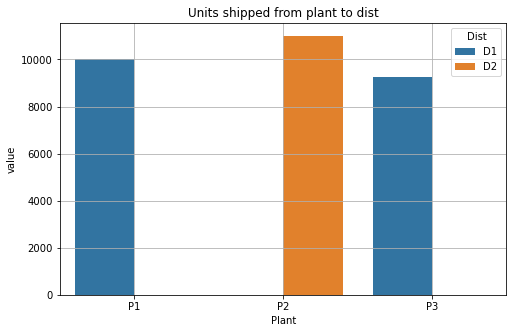

In [98]:
melted_dist = md.df_plant
melted_dist = pd.melt(md.df_plant)
melted_dist['Plant'] = md.DVX*2
plt.figure(figsize=(8,5))
sns.barplot(x = 'Plant', y = 'value', hue = 'variable', data = melted_dist)
plt.grid()
plt.legend(title = "Dist")
plt.title("Units shipped from plant to dist")
plt.show()

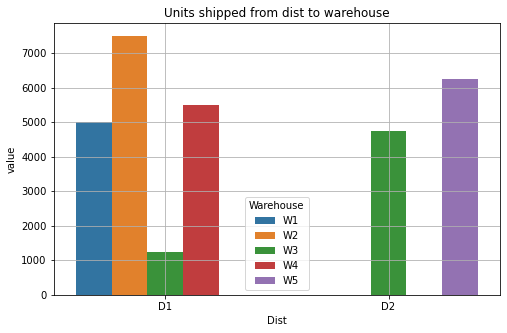

In [99]:
melted_dist = md.df_dist
melted_dist = pd.melt(md.df_dist)
melted_dist['Dist'] = md.DV1*5
plt.figure(figsize=(8,5))
sns.barplot(x = 'Dist', y = 'value', hue = 'variable', data = melted_dist)
plt.grid()
plt.legend(title = "Warehouse")
plt.title("Units shipped from dist to warehouse")
plt.show()

#### Problem 6

In [100]:
p3_d1_costs = [(i + 50)/100 for i in list(range(0, 21))]
obj_vals = []
for cost in p3_d1_costs:
    md.c1.loc[c1_change[0], c1_change[1]] = cost
    md.run()
    obj_vals.append(md.obj_val)
result = zip(p3_d1_costs, obj_vals)
c1_change_title = f"{c1_change[0]}-{c1_change[1]}"
df_cost_change = pd.DataFrame(zip(p3_d1_costs, obj_vals), columns=[c1_change_title, "Cost"])
df_cost_change

,P3-D1,Cost
0,0.50,29725.0
1,0.51,29830.0
2,0.52,29935.0
3,0.53,30040.0
4,0.54,30145.0
5,0.55,30250.0
6,0.56,30342.5
7,0.57,30435.0
8,0.58,30527.5
9,0.59,30620.0


#### Problem 6a

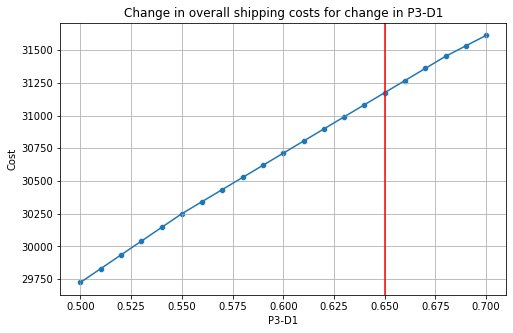

In [101]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = c1_change_title, y = 'Cost', data = df_cost_change)
sns.lineplot(x = c1_change_title, y = 'Cost', data = df_cost_change)
plt.grid()
plt.axvline(x = .65, color = "red")
plt.title(f"Change in overall shipping costs for change in {c1_change_title}")
plt.show()

#### Problem 6b

In [102]:
DV_list_plant = []
DV_list_dist = []
for val in p3_d1_costs:
    DV_curr_list_plant = []
    DV_curr_list_dist = []
    md.c1.loc[c1_change[0], c1_change[1]] = val
    md.run()
    for c in md.mod.P3:
        DV_curr_list_plant.append(md.mod.P3[c].value)
    for DV in [getattr(md.mod, d) for d in md.DV1]:
        for c in DV:
            DV_curr_list_dist.append(DV[c].value)
    DV_list_plant.append(DV_curr_list_plant)
    DV_list_dist.append(DV_curr_list_dist)

DV_df_plant = pd.DataFrame(DV_list_plant, columns=["P3-D1", "P3-D2"])
DV_df_dist = pd.DataFrame(DV_list_dist, columns= [f"{d}-{w}" for d in md.DV1 for w in md.DV2])
DV_df_plant["Costs"] = p3_d1_costs
DV_df_dist["Costs"] = p3_d1_costs
DV_df_plant

,P3-D1,P3-D2,Costs
0,10500.0,0.0,0.50
1,10500.0,0.0,0.51
2,10500.0,0.0,0.52
3,10500.0,0.0,0.53
4,10500.0,0.0,0.54
5,10500.0,0.0,0.55
6,9250.0,0.0,0.56
7,9250.0,0.0,0.57
8,9250.0,0.0,0.58
9,9250.0,0.0,0.59


In [103]:
DV_df_dist

,D1-W1,D1-W2,D1-W3,D1-W4,D1-W5,D2-W1,D2-W2,D2-W3,D2-W4,D2-W5,Costs
0,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.50
1,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.51
2,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.52
3,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.53
4,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.54
5,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.55
6,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.56
7,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.57
8,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.58
9,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.59


In [104]:
melted_plant = pd.melt(DV_df_plant, "Costs", value_name="Value")
melted_dist = pd.melt(DV_df_dist, "Costs", value_name="Value")
melted_plant

,Costs,variable,Value
0,0.50,P3-D1,10500.0
1,0.51,P3-D1,10500.0
2,0.52,P3-D1,10500.0
3,0.53,P3-D1,10500.0
4,0.54,P3-D1,10500.0
5,0.55,P3-D1,10500.0
6,0.56,P3-D1,9250.0
7,0.57,P3-D1,9250.0
8,0.58,P3-D1,9250.0
9,0.59,P3-D1,9250.0


In [105]:
melted_dist

,Costs,variable,Value
0,0.50,D1-W1,5000.0
1,0.51,D1-W1,5000.0
2,0.52,D1-W1,5000.0
3,0.53,D1-W1,5000.0
4,0.54,D1-W1,5000.0
...,...,...,...
205,0.66,D2-W5,6250.0
206,0.67,D2-W5,6250.0
207,0.68,D2-W5,6250.0
208,0.69,D2-W5,6250.0


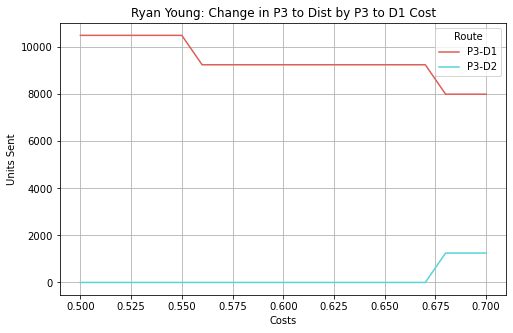

In [106]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'Value', hue = 'variable', palette = sns.color_palette("hls", 2),
             data = melted_plant)
plt.grid()
plt.title(f'Ryan Young: Change in P3 to Dist by {c1_change[0]} to {c1_change[1]} Cost')
plt.ylabel('Units Sent')
plt.legend(title = "Route")
plt.show()

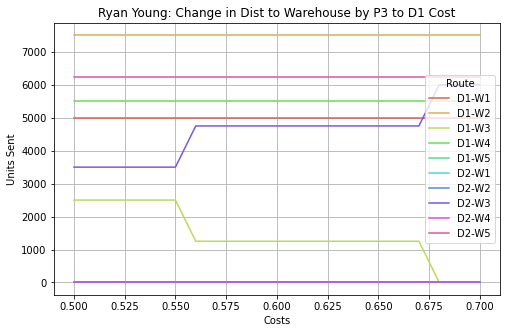

In [107]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'Value', hue = 'variable', palette = sns.color_palette("hls", 10),
             data = melted_dist)
plt.grid()
plt.title(f'Ryan Young: Change in Dist to Warehouse by {c1_change[0]} to {c1_change[1]} Cost')
plt.ylabel('Units Sent')
plt.legend(title = "Route")
plt.show()

#### Problem 7

In [108]:
demand_w3 = [i*100 + 4700 for i in list(range(0, 27))]
obj_vals = []
for cost in demand_w3:
    md.demand.loc["W3", "Requirement"] = cost
    md.run()
    obj_vals.append(md.obj_val)
result = zip(demand_w3, obj_vals)
df_cost_change = pd.DataFrame(zip(demand_w3, obj_vals), columns=["W3-Demand", "Obj"])
df_cost_change

,W3-Demand,Obj
0,4700,30342.5
1,4800,30436.5
2,4900,30534.5
3,5000,30632.5
4,5100,30730.5
5,5200,30828.5
6,5300,30926.5
7,5400,31024.5
8,5500,31122.5
9,5600,31220.5


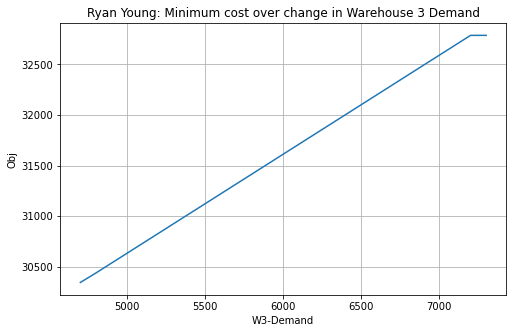

In [109]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'W3-Demand', y = 'Obj', data = df_cost_change)
plt.grid()
plt.title("Ryan Young: Minimum cost over change in Warehouse 3 Demand")
plt.show()